In [1]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

2024-06-04 18:44:44.268855: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 18:44:44.311738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 18:44:45.380657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# Cargar los datos
#obtener el ultuimoa archivo csv en la ruta

def load_data(path: str)-> pd.DataFrame:
    list_of_files = glob.glob(f'{path}*.csv')
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    data = pd.read_csv(latest_file)
    return data



In [7]:
# Visualizar los datos de entrenamiento
data_ = load_data('data/backups/')
data = data_.copy()
display(data.head())
print(data.shape)

data/backups/frames20240530215156.csv


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,209,211,212,211,212,213,212,213,212,...,69,70,76,119,163,193,198,198,197,196
1,0,196,212,213,213,213,213,213,213,214,...,78,92,114,191,197,197,199,199,197,195
2,0,179,183,210,212,212,213,213,214,215,...,80,93,125,197,200,201,203,203,202,196
3,0,112,161,179,191,207,213,213,214,214,...,88,99,155,203,204,205,205,205,198,128
4,0,112,147,158,171,185,200,210,212,212,...,89,101,125,203,204,205,205,204,198,123


(3800, 785)


In [9]:
# Verificar la cantidad de clases en el conjunto de datos
labels = data['label'].values
unique_val = np.array(labels)
labels_unique = np.unique(unique_val)
print(labels_unique.tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [10]:
# Eliminar la columna de etiquetas del conjunto de datos de entrenamiento
data.drop('label', axis = 1, inplace=True)

In [12]:
# Convertir un registro por clase de la tabla de datos a imagen
images = data.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array(images).astype(float)

# Hot One encoding de las etiquetas
label_binrizer = LabelBinarizer()
print(data_['label'].value_counts())
labels_ = label_binrizer.fit_transform(data_['label'])
print(pd.DataFrame(labels_).value_counts())   



label
0     200
1     200
2     200
3     200
4     200
5     200
6     200
7     200
8     200
9     200
10    200
11    200
12    200
13    200
14    200
15    200
16    200
17    200
18    200
Name: count, dtype: int64
0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18
0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   1     200
                                                          1   0     200
                                                      1   0   0     200
                                                  1   0   0   0     200
                                              1   0   0   0   0     200
                                          1   0   0   0   0   0     200
                                      1   0   0   0   0   0   0     200
                                  1   0   0   0   0   0   0   0     200
                              1   0   0   0   0   0   0   0   0     200
                           1  0   0   0   0   0   0   0   0   0  

In [13]:
# Partir los datos en entrenamiento, validación y testeo
x_train, x_test, y_train, y_test = train_test_split(images, labels_, test_size = 0.3, random_state = 101)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 101)

# Definir los parametros de la red neuronal
img_rows, img_cols = 28, 28
batch_size = 128
epochs = 50
num_classes = len(labels_[0])

# Redimensionar los datos de entrenamiento y validación para que tengan la forma (n, 28, 28, 1)
print(x_train.shape), print(x_test.shape), print(x_val.shape)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

(2660, 28, 28)
(570, 28, 28)
(570, 28, 28)


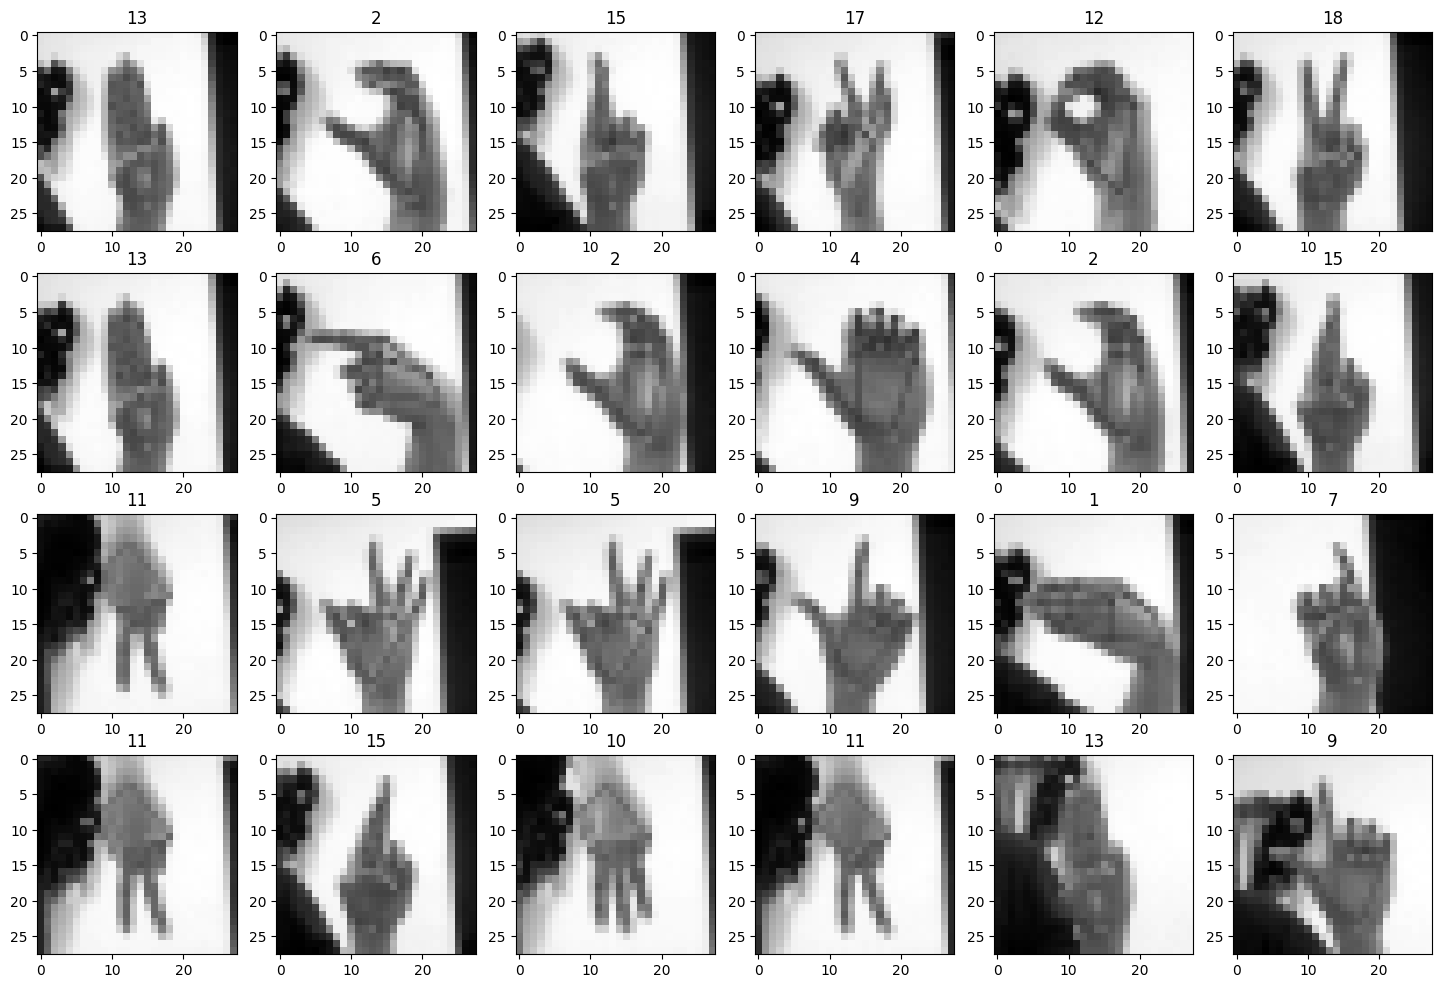

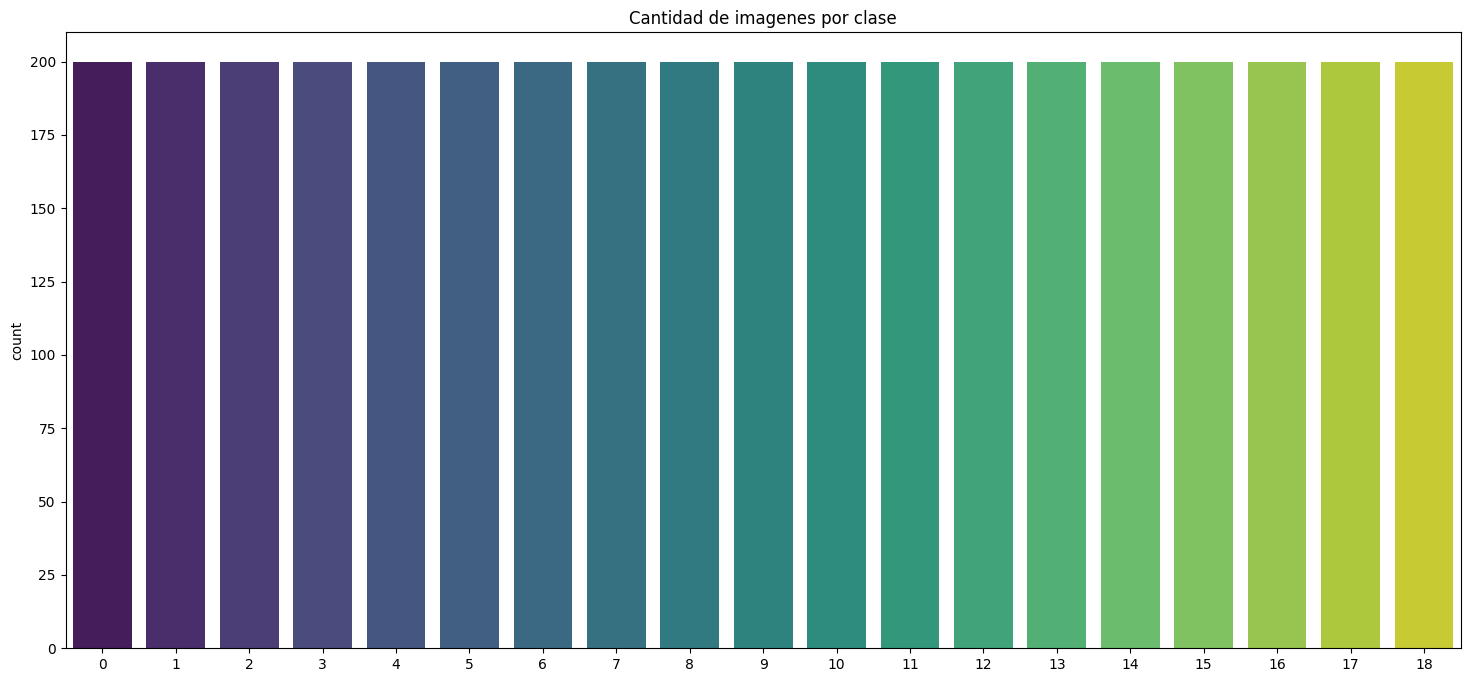

In [14]:
# Visualizar una imagen aleatoria por clase
plt.figure(figsize=(18,12))
for i in range(24):
    random_num = np.random.randint(0, len(images))
    plt.subplot(4, 6, i+1)
    plt.imshow(images[random_num], cmap='gray')
    plt.title(labels[random_num])
plt.show()

# Visualizar la cantidad de imagenes por clase
plt.figure(figsize=(18,8))
sns.countplot(x=labels, palette="viridis")
plt.title('Cantidad de imagenes por clase')
plt.show()

In [15]:
# Crear la red neuronal convolucional

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(28, 28 ,1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))

model.add(Dense(num_classes, activation = 'softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Visualizar el resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,267 (333.07 KB)

 Trainable params: 85,267 (333.07 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.0721 - loss: 11.6853 - val_accuracy: 0.1825 - val_loss: 2.7059
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2274 - loss: 2.5681 - val_accuracy: 0.5667 - val_loss: 1.8215
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5363 - loss: 1.6431 - val_accuracy: 0.8158 - val_loss: 0.8257
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7841 - loss: 0.8269 - val_accuracy: 0.9719 - val_loss: 0.3029
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8856 - loss: 0.4622 - val_accuracy: 0.9772 - val_loss: 0.2116
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9400 - loss: 0.3120 - val_accuracy: 0.9789 - val_loss: 0.1732
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9593 - loss: 0.2519 - val_accuracy: 0.9789 - val_loss: 0.1581
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9734 - loss: 0.1795 - val_accuracy: 0.9807 - 

In [100]:
# Guardar el modelo
model.save('models/model3.h5')

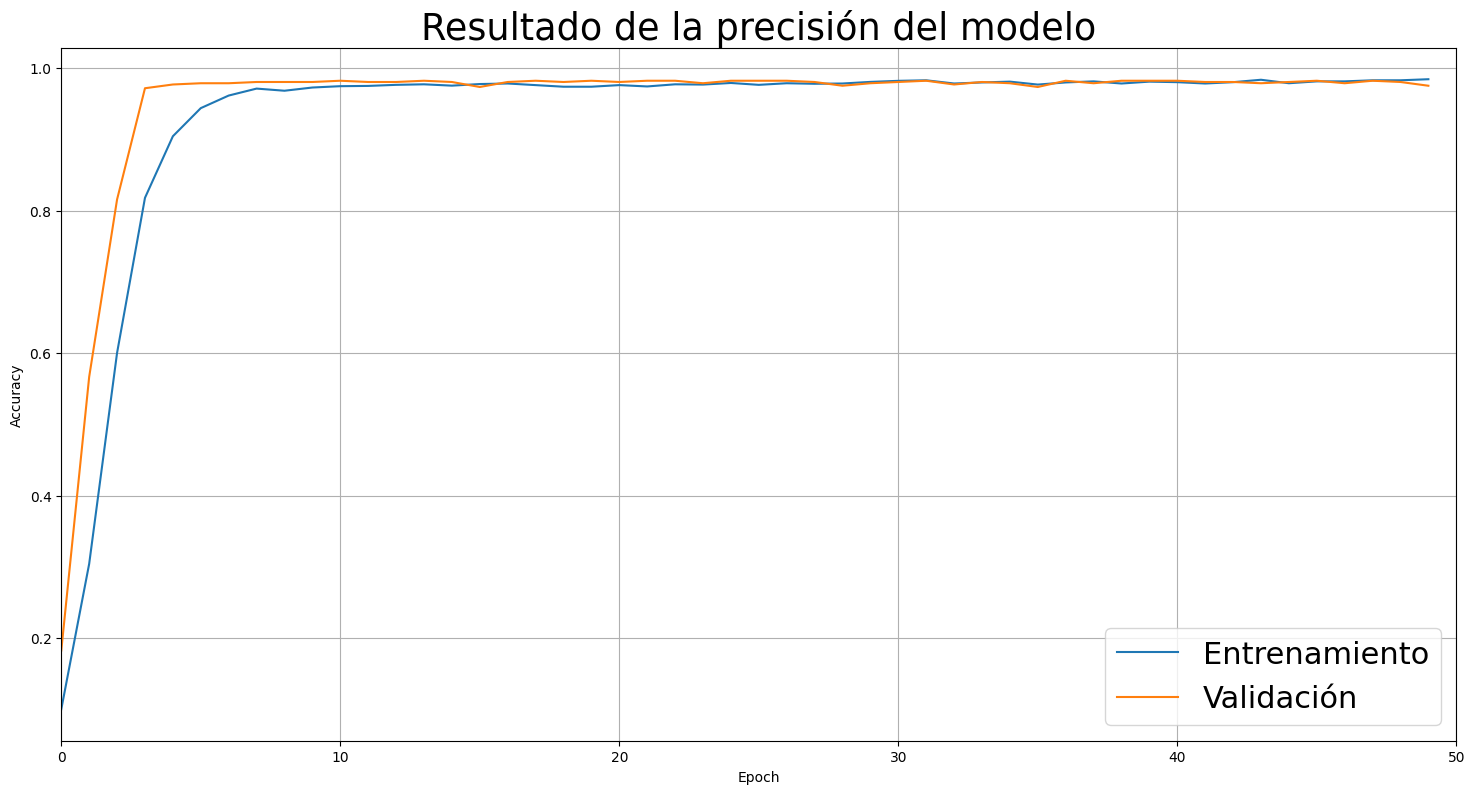

In [17]:
# Visualizar la precisión del modelo
plt.figure(figsize=(18,9))
plt.xlim(0, epochs)
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(['Entrenamiento', 'Validación'], loc = 'lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Resultado de la precisión del modelo')
plt.grid()
plt.show()

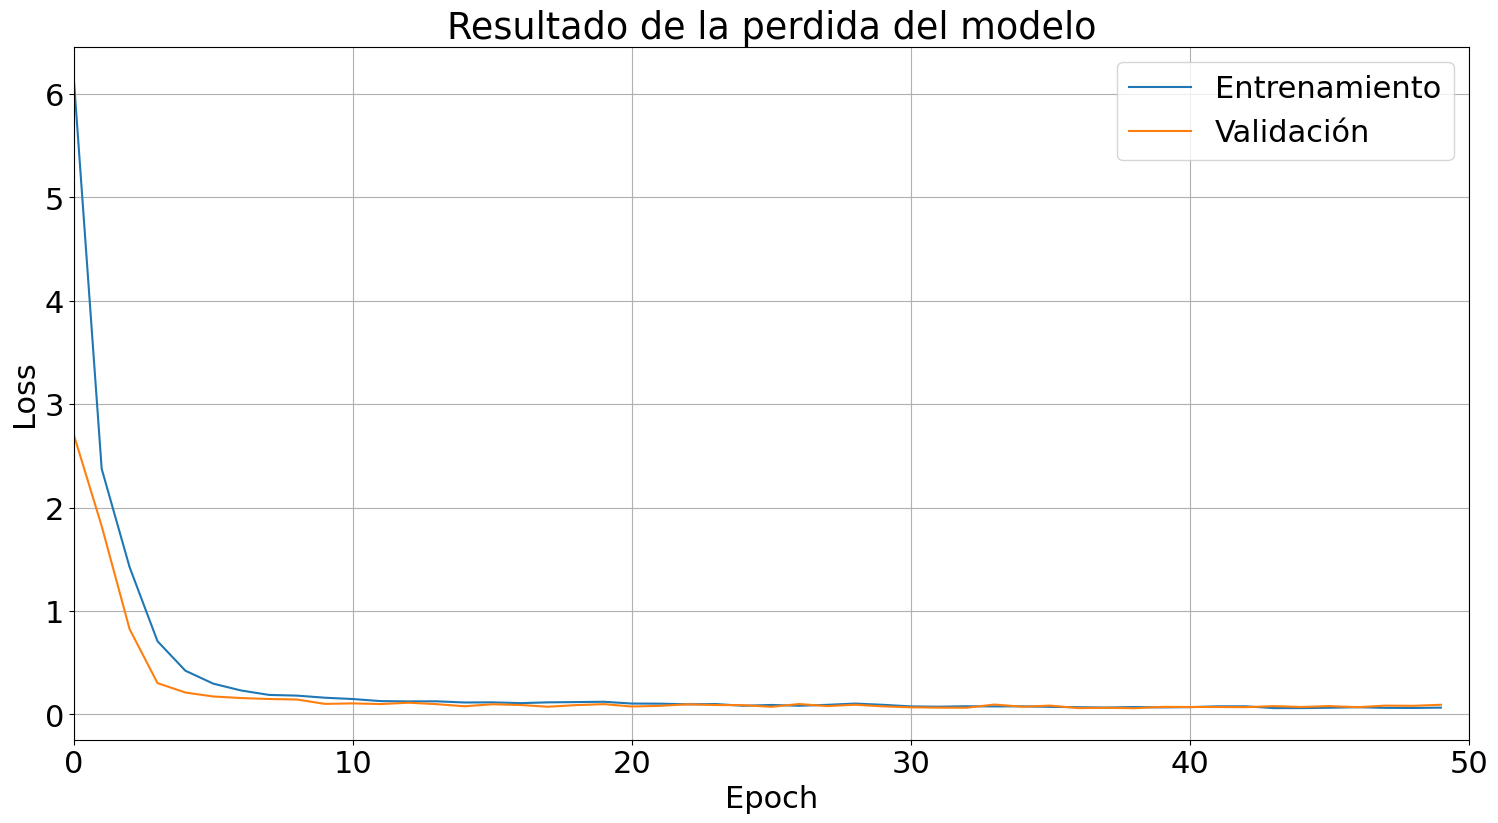

In [18]:
#visualizar la perdida del modelo
plt.figure(figsize=(18,9))
plt.xlim(0, epochs)
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(['Entrenamiento', 'Validación'], loc = 'upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Resultado de la perdida del modelo')
plt.grid()
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Precisión del modelo: 97.89%


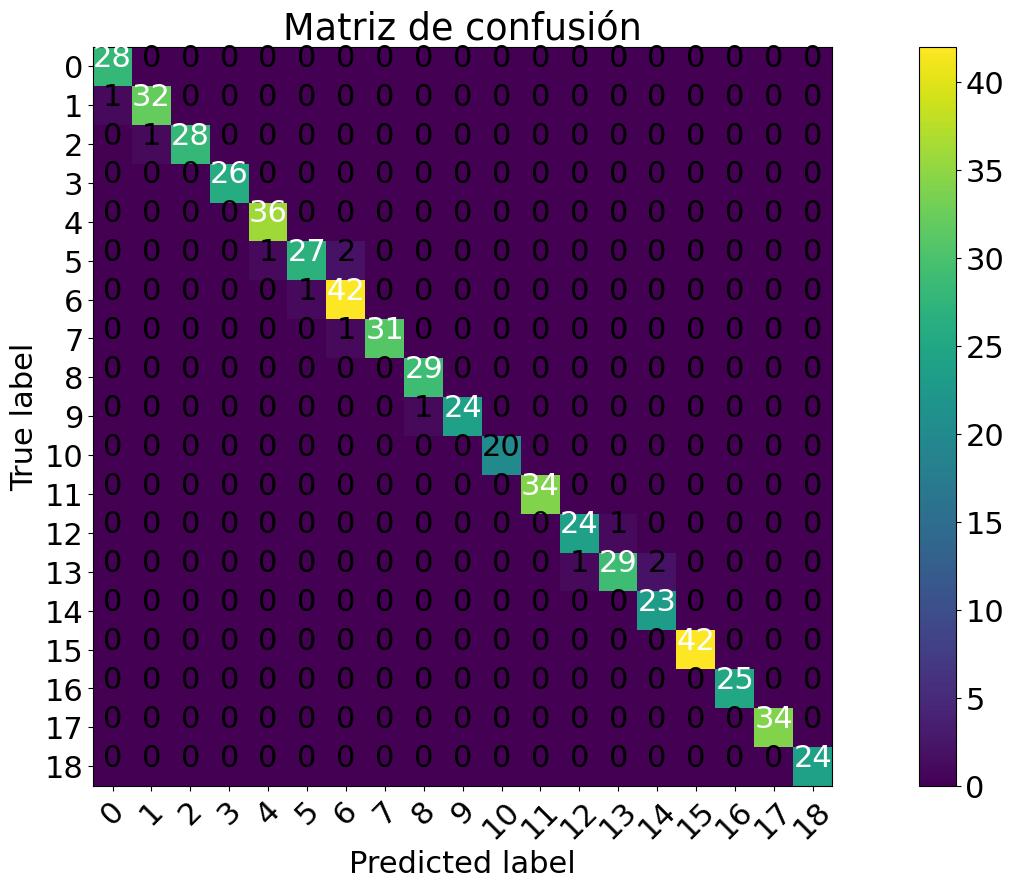

In [125]:
# visualizar la matriz de confusión
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(18,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predecir las etiquetas de las imágenes de testeo
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
plot_confusion_matrix(confusion_mtx, classes = labels_unique, title='Matriz de confusión', normalize=False, cmap=plt.cm.viridis)

# Calcular la precisión del modelo
accuracy= accuracy_score(y_true, y_pred_classes)
print('Precisión del modelo: {:.2f}%'.format(accuracy*100))
